In [12]:
# Studying a piece of land and analyzing the geography for use with irrigation

# Add the Python ArcGIS package to the default Anaconda packages that were installed during Navigator install
!pip install arcgis

In [ ]:
import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from ipywidgets import *

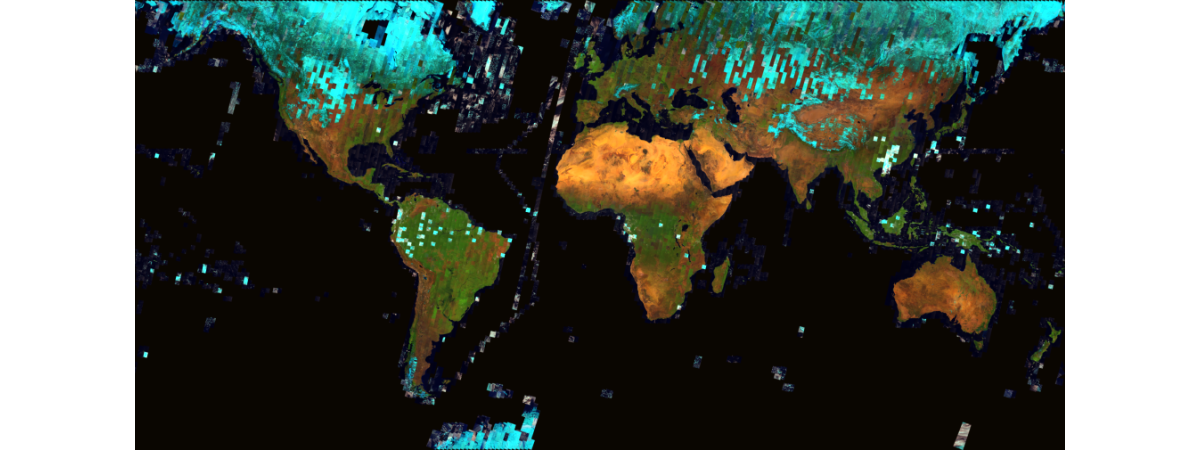

In [13]:
gis = GIS()

arcgis.raster.analytics.is_supported(gis)

search_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = search_item.layers[0]

landsat

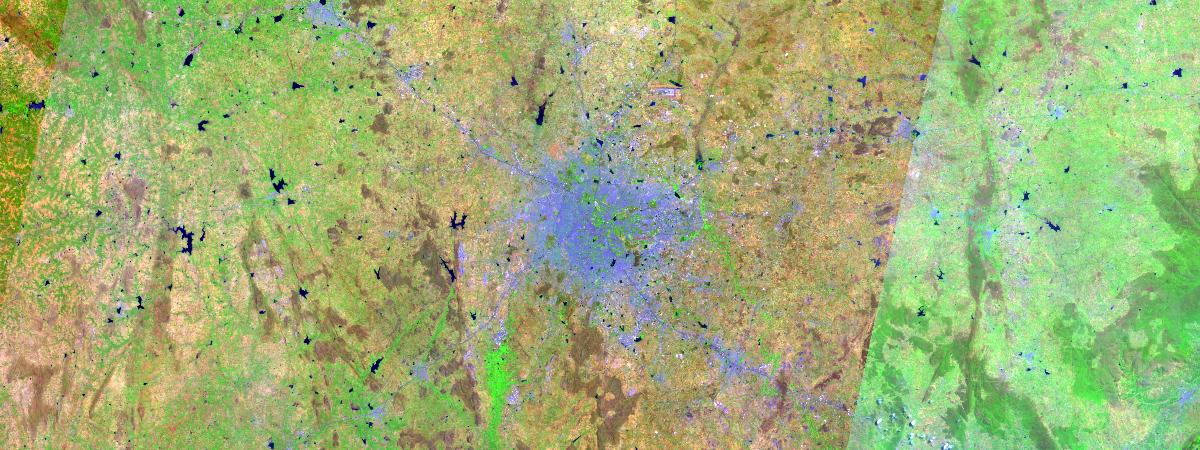

In [14]:
# Access ArcGIS online tools to get a satellite image of the Bangalore region

from arcgis.geocoding import geocode

extent = geocode("Kandi", "India", out_sr=landsat.properties.spatialReference)[1]
landsat.extent = extent['extent']
landsat

In [4]:
# Use the GMRT online mapping tool to get terrain for an area east of Bangalore
# https://www.gmrt.org/GMRTMapTool/

# Bangalore is centered at: [12.971599, 77.594566]
# So use bounds of [12.99, 77.59] and [13.01, 77.57]

# Save the terrain grid as ArcASCII File Format, and High Grid Resolution
# It downloads an .asc file with 39 columns and 35 rows

# Read in the terrain to a two-dimensional array:

import numpy as np

Terrain  = np.loadtxt("kandiregiongridmap.asc", skiprows=6)
print(Terrain[1][12])

1205.28


Matplotlib created a temporary config/cache directory at /var/folders/zf/49prmn_s7s5861rytkmr3_080000gn/T/matplotlib-vjgs3qlg because the default path (/Users/ribells/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


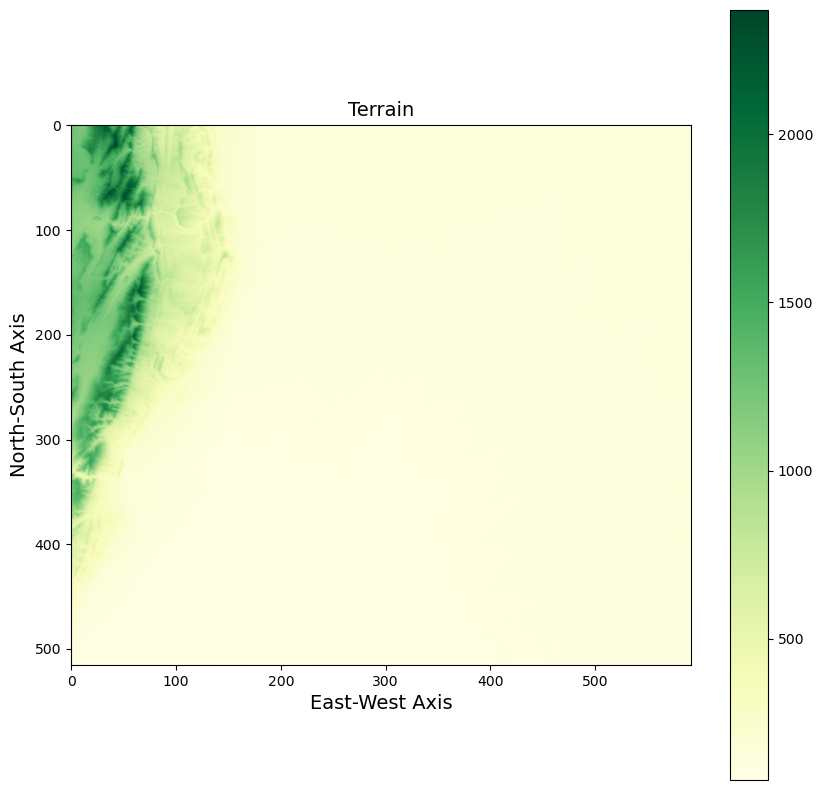

In [5]:
#Plot the terrain to see it visually

import matplotlib.pyplot as plt
from PIL import Image  #images processing package

def plot_terrain():
    #plot vegetation cover
    plt.figure(figsize=(10, 10))
    plt.imshow(Terrain)

    plt.xlabel('East-West Axis', fontsize=14)
    plt.ylabel('North-South Axis', fontsize=14)
    plt.title('Terrain', fontsize=14);
    plt.set_cmap("YlGn")
    plt.colorbar()
    
    plt.show()
        
plot_terrain()

In [6]:
# Set a uniform soil depth at all locations

nx = len(Terrain[0])
ny = len(Terrain)

# create soil data array
Soil = np.zeros([ny, nx], dtype = float)

def fill_soil_grid():
    #fill the Soil grid
    for i in range(0, nx): #march east to west
        for j in range(0, ny): #march south to north
            Soil[j][i] = 2

fill_soil_grid()

print (Soil)

[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]


In [7]:
# Set a uniform water table depth at all locations

nx = len(Terrain[0])
ny = len(Terrain)

# create soil data array
Winit = np.zeros([ny, nx], dtype = float)

def fill_water_table_grid():
    #fill the Water grid
    for i in range(0, nx): #march east to west
        for j in range(0, ny): #march south to north
            Winit[j][i] = 1

fill_water_table_grid()

print (Winit)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [30]:
# Set a uniform vegetation amount at all locations (consider changing that over a season)

nx = len(Terrain[0])
ny = len(Terrain)

# create soil data array
Vegetation = np.zeros([ny, nx], dtype = float)

def fill_vegetation_grid():
    #fill the Vegetation grid
    for i in range(0, nx): #march east to west
        for j in range(0, ny): #march south to north
            #0 is completely vegetated, 255 is no plant life (valid range is 0-255)
            Vegetation[j][i] = 255

fill_vegetation_grid()

print (Vegetation)

[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]


In [9]:
#Calculate the water surface flow

import numpy as np

def calculate_flow(dem):
    rows, cols = dem.shape
    flow_direction = np.zeros((rows, cols), dtype=int)
    flow_slope = np.zeros((rows, cols), dtype=float)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            max_slope = 0
            direction = 0
            current_elevation = dem[i, j]
            for di, dj, d in [(-1, 0, 1), (1, 0, 1), (0, -1, 1), (0, 1, 1), (-1, -1, np.sqrt(2)), (-1, 1, np.sqrt(2)), (1, -1, np.sqrt(2)), (1, 1, np.sqrt(2))]:
                neighbor_elevation = dem[i + di, j + dj]
                slope = (current_elevation - neighbor_elevation) / d
                if slope > max_slope:
                    max_slope = slope
                    direction = (di + 1) * 3 + (dj + 1)
            flow_direction[i, j] = direction
            flow_slope[i, j] = max_slope
    return [flow_direction, flow_slope]

# Example DEM
dem = Terrain

result = calculate_flow(dem)
flow_direction = result[0]
slope = result[1]

print(slope[3][3])

8.3599999999999


In [31]:
# Run a hydrology model that drives water movement
# See tutorials at https://www.hec.usace.army.mil/confluence/hmsdocs/hmsguides

import numpy as np     #numeric processing package
import math as math    #mathematics functions package
import random

river_flow = 2.855e10 # cm^3/second  #flow of river at start

#Define the Parameters (lengths all in cm)
L=390000;  # length of estuary in cm (3.9 kilometers) East-West Distance
h=350000;  # width of estuary in cm (3.5 kilometers)  North-South Distance
dx=10000;  # E-W grid spacing in cm (100 meters) East-West Spacing
dy=10000;  # N-S grid spacing in cm (100 meters) North-South Spacing

#Factors controlling water diffusion
Kh=2.895e-5; # TO RESEARCH: horizontal diffusivity (2.895 x 10^-5 cm^2/s)
Kv=2.895e-5; # TO RESEARCH: vertical diffusivity   (2.895 x 10^-5 cm^2/s)

ntimes=7*24+1; # number of time steps (seven days)
dt=3600;       # time per time step (one hour)

# using kandi hydro proj.pdf for guidance...

# create precipitation data array
Precip = np.zeros([ny, nx], dtype = float)

def fill_precipitation_grid():
    #fill the Precipitation grid
    for i in range(0, nx): #march east to west
        for j in range(0, ny): #march south to north
            #0 is completely vegetated, 255 is no plant life (valid range is 0-255)
            Precip[j][i] = (800 + random.random()*(700))/(365.25*24) # annual amount of rain

fill_precipitation_grid()

def calculate_growth_rate(water_table, precipitation, water_coefficient, precip_coefficient):
    growth_rate = (water_table.mean() * water_coefficient) + (precipitation.mean() * precip_coefficient)
    return growth_rate

print (Precip)

# Here is the URL from which I got my data:
# 

#Precip = [ #total precipitation for 35 (length) x 39 (width) 2-D array
#    [0.129,1.0304,2.9286,2.8248,2.7196,2.6136,2.5073,2.4008,2.2945,2.1884,2.0827,2.9775,2.8727,2.7683,2.6644,2.5609,2.4578,2.355,2.2525,2.1502,2.0481,2.9462,2.8444,2.7427,2.6411,2.5395,2.438,2.3366,2.2351,2.1337,2.0323,3.9309,3.8296,3.7282,3.6268,3.5254,3.4241,3.3227,3.2213],
#    [0.129,1.0304,2.9286,2.8248,2.7196,2.6136,2.5073,2.4008,2.2945,2.1884,2.0827,2.9775,2.8727,2.7683,2.6644,2.5609,2.4578,2.355,2.2525,2.1502,2.0481,2.9462,2.8444,2.7427,2.6411,2.5395,2.438,2.3366,2.2351,2.1337,2.0323,3.9309,3.8296,3.7282,3.6268,3.5254,3.4241,3.3227,3.2213],
#    [0.1935,1.08,2.9676,2.856,2.7453,2.6353,2.5261,2.4175,2.3097,2.2027,2.0963,2.9906,2.8856,2.7811,2.6772,2.5738,2.4707,2.3681,2.2657,2.1637,2.0618,2.9601,2.8585,2.757,2.6557,2.5544,2.4531,2.3519,2.2507,2.1495,2.0483,3.9471,3.846,3.7448,3.6437,3.5425,3.4414,3.3403,3.2391],
#    [0.2581,1.1368,1.0178,2.9009,2.7858,2.6724,2.5605,2.45,2.3407,2.2327,2.1257,2.0196,2.9144,2.81,2.7062,2.603,2.5003,2.398,2.296,2.1944,2.0929,2.9916,2.8905,2.7895,2.6886,2.5877,2.4869,2.3861,2.2854,2.1846,2.0839,3.9832,3.8825,3.7818,3.6811,3.5804,3.4797,3.379,3.2783],
#    [0.3226,1.1966,1.0736,2.9534,2.8356,2.7201,2.6066,2.4949,2.3849,2.2764,2.1692,2.0632,2.9582,2.8541,2.7507,2.648,2.5458,2.4441,2.3427,2.2417,2.1408,2.0402,2.9398,2.8394,2.7391,2.6389,2.5388,2.4387,2.3386,2.2385,2.1385,2.0384,3.9384,3.8383,3.7383,3.6383,3.5382,3.4382,3.3382],
#    [0.3871,1.2584,1.1332,1.0112,2.8921,2.7756,2.6615,2.5496,2.4395,2.3311,2.2243,2.1187,2.0142,2.9107,2.8081,2.7061,2.6047,2.5038,2.4033,2.3031,2.2031,2.1034,2.0038,2.9043,2.8049,2.7056,2.6063,2.5071,2.4078,2.3086,2.2094,2.1103,2.0111,3.9119,3.8127,3.7136,3.6144,3.5152,3.4161],
#    [0.4516,1.3216,1.1956,1.073,2.9537,2.8372,2.7234,2.6118,2.5023,2.3946,2.2885,2.1837,2.0802,2.9776,2.876,2.775,2.6747,2.5749,2.4754,2.3763,2.2774,2.1787,2.0802,2.9818,2.8834,2.7852,2.687,2.5888,2.4906,2.3925,2.2944,2.1963,2.0982,2.0001,3.902,3.8039,3.7058,3.6077,3.5096],
#    [0.5161,1.3862,1.2604,1.1383,1.0196,2.9039,2.7909,2.6803,2.5719,2.4653,2.3603,2.2568,2.1545,2.0532,2.9528,2.8531,2.7541,2.6555,2.5573,2.4595,2.3619,2.2645,2.1672,2.0701,2.973,2.876,2.7791,2.6822,2.5853,2.4885,2.3916,2.2948,2.1979,2.1011,2.0043,3.9075,3.8106,3.7138,3.617],
#    [0.5806,1.452,1.3275,1.2068,1.0895,2.9752,2.8637,2.7545,2.6476,2.5425,2.439,2.337,2.2362,2.1364,2.0375,2.9394,2.8418,2.7447,2.648,2.5517,2.4556,2.3597,2.2639,2.1683,2.0727,2.9772,2.8817,2.7863,2.6909,2.5955,2.5002,2.4048,2.3094,2.2141,2.1187,2.0234,3.928,3.8327,3.7373],
#    [0.6452,1.5189,1.3966,1.2781,1.1629,1.0507,2.9411,2.8339,2.7289,2.6256,2.524,2.4238,2.3248,2.2267,2.1296,2.0332,2.9373,2.842,2.747,2.6523,2.5579,2.4637,2.3696,2.2757,2.1818,2.088,2.9942,2.9005,2.8068,2.7131,2.6194,2.5257,2.432,2.3384,2.2447,2.1511,2.0574,3.9637,3.8701],
#    [0.7097,1.5868,1.4677,1.3521,1.2397,1.1301,1.023,2.9182,2.8154,2.7144,2.6149,2.5167,2.4197,2.3237,2.2285,2.1341,2.0402,2.9467,2.8537,2.7609,2.6684,2.5761,2.4839,2.3918,2.2998,2.2079,2.116,2.0242,2.9323,2.8405,2.7487,2.6569,2.5651,2.4734,2.3816,2.2898,2.198,2.1062,2.0145],
#    [0.7742,1.6556,1.5405,1.4286,1.3195,1.2131,1.1089,1.0069,2.9067,2.8082,2.7111,2.6153,2.5206,2.4268,2.3338,2.2415,2.1497,2.0584,2.9674,2.8768,2.7863,2.6961,2.606,2.516,2.4261,2.3362,2.2464,2.1566,2.0669,2.9771,2.8874,2.7977,2.7079,2.6182,2.5285,2.4388,2.3491,2.2594,2.1697],
#    [0.8387,1.7253,1.6149,1.5073,1.4021,1.2993,1.1985,1.0996,1.0024,2.9066,2.8122,2.719,2.6267,2.5354,2.4448,2.3548,2.2653,2.1762,2.0875,2.9991,2.9109,2.8229,2.7351,2.6473,2.5596,2.472,2.3844,2.2969,2.2093,2.1218,2.0343,2.9468,2.8593,2.7719,2.6844,2.5969,2.5094,2.4219,2.3345],
#    [0.9032,1.7957,1.6906,1.5878,1.487,1.3882,1.2911,1.1956,1.1016,1.009,2.9174,2.827,2.7374,2.6486,2.5605,2.473,2.386,2.2993,2.2131,2.127,2.0412,2.9556,2.8701,2.7847,2.6994,2.6141,2.5289,2.4437,2.3585,2.2734,2.1882,2.1031,2.018,2.9329,2.8477,2.7626,2.6775,2.5924,2.5073],
#    [0.9677,1.8666,1.7673,1.6697,1.5737,1.4793,1.3862,1.2944,1.2039,1.1144,1.026,2.9384,2.8517,2.7656,2.6802,2.5952,2.5108,2.4267,2.3429,2.2593,2.176,2.0928,2.0098,2.9268,2.844,2.7611,2.6784,2.5956,2.5129,2.4302,2.3475,2.2649,2.1822,2.0995,2.0169,2.9342,2.8515,2.7689,2.6862],
#    [0.0323,1.9379,1.8447,1.7527,1.6618,1.5719,1.4831,1.3952,1.3083,1.2223,1.137,1.0525,2.9686,2.8854,2.8027,2.7204,2.6385,2.557,2.4758,2.3948,2.314,2.2333,2.1528,2.0723,2.9919,2.9116,2.8314,2.7511,2.6709,2.5907,2.5105,2.4304,2.3502,2.27,2.1898,2.1097,2.0295,2.9494,2.8692],
#    [0.0968,0.0094,1.9226,1.8364,1.7507,1.6656,1.5811,1.4973,1.4142,1.3316,1.2496,1.1682,1.0873,1.0069,2.927,2.8474,2.7682,2.6892,2.6106,2.5321,2.4538,2.3757,2.2976,2.2197,2.1418,2.064,2.9863,2.9085,2.8308,2.7531,2.6754,2.5977,2.5201,2.4424,2.3647,2.2871,2.2094,2.1317,2.0541],
#    [0.1613,0.081,0.0007,1.9203,1.8399,1.7597,1.6798,1.6001,1.5207,1.4416,1.363,1.2847,1.2068,1.1293,1.0521,2.9752,2.8985,2.8222,2.746,2.6701,2.5943,2.5186,2.443,2.3676,2.2922,2.2168,2.1415,2.0662,2.9909,2.9157,2.8405,2.7652,2.69,2.6148,2.5396,2.4644,2.3892,2.3139,2.2387],
#    [0.2258,0.1526,0.0786,0.0041,1.9291,1.8538,1.7784,1.7028,1.6272,1.5518,1.4764,1.4012,1.3263,1.2515,1.177,1.1028,1.0287,2.9548,2.8811,2.8076,2.7342,2.6609,2.5877,2.5146,2.4416,2.3686,2.2956,2.2227,2.1498,2.0769,2.0041,2.9312,2.8583,2.7855,2.7126,2.6398,2.5669,2.4941,2.4212],
#    [0.2903,0.224,0.1564,0.0877,0.018,1.9476,1.8766,1.8051,1.7334,1.6614,1.5893,1.5172,1.4451,1.3731,1.3012,1.2294,1.1578,1.0863,1.015,2.9437,2.8726,2.8016,2.7307,2.6598,2.589,2.5183,2.4475,2.3769,2.3062,2.2355,2.1649,2.0942,2.0236,2.953,2.8824,2.8118,2.7411,2.6705,2.5999],
#    [0.3548,0.2952,0.2337,0.1707,0.1063,0.0406,1.9741,1.9066,1.8386,1.7701,1.7012,1.632,1.5627,1.4933,1.424,1.3546,1.2853,1.216,1.1469,1.0778,1.0088,2.9399,2.8711,2.8023,2.7336,2.6649,2.5963,2.5277,2.459,2.3905,2.3219,2.2533,2.1848,2.1162,2.0477,2.9791,2.9106,2.842,2.7735],
#    [0.4194,0.3661,0.3105,0.253,0.1937,0.1328,0.0705,0.0071,1.9427,1.8775,1.8117,1.7454,1.6788,1.6119,1.5449,1.4778,1.4107,1.3435,1.2764,1.2093,1.1423,1.0754,1.0084,2.9416,2.8747,2.808,2.7412,2.6745,2.6077,2.541,2.4743,2.4077,2.341,2.2743,2.2076,2.141,2.0743,2.0077,2.941],
#    [0.4839,0.4366,0.3868,0.3345,0.2801,0.2238,0.1657,0.1062,0.0453,1.9834,1.9206,1.8571,1.7931,1.7286,1.6638,1.5988,1.5337,1.4685,1.4033,1.338,1.2728,1.2075,1.1423,1.0772,1.0121,2.947,2.8819,2.8168,2.7518,2.6868,2.6218,2.5568,2.4918,2.4268,2.3618,2.2969,2.2319,2.1669,2.1019],
#    [0.5484,0.5068,0.4623,0.4151,0.3654,0.3135,0.2595,0.2037,0.1463,0.0876,0.0277,1.9669,1.9053,1.8431,1.7804,1.7174,1.6541,1.5907,1.5272,1.4635,1.3999,1.3362,1.2726,1.2089,1.1453,1.0817,1.0181,2.9545,2.891,2.8274,2.7639,2.7004,2.6369,2.5734,2.5099,2.4464,2.3829,2.3194,2.2559],
#    [0.6129,0.5765,0.537,0.4946,0.4494,0.4017,0.3516,0.2994,0.2453,0.1897,0.1326,0.0743,0.015,1.955,1.8943,1.8331,1.7715,1.7097,1.6476,1.5855,1.5232,1.4609,1.3986,1.3363,1.2739,1.2116,1.1493,1.087,1.0248,2.9625,2.9002,2.838,2.7757,2.7135,2.6513,2.589,2.5268,2.4646,2.4024],
#    [0.6774,0.6457,0.6107,0.5726,0.5316,0.4877,0.4413,0.3925,0.3415,0.2887,0.2342,0.1783,0.1212,0.0631,0.0042,1.9447,1.8846,1.8242,1.7635,1.7026,1.6416,1.5805,1.5193,1.4581,1.3968,1.3356,1.2744,1.2132,1.152,1.0908,1.0296,2.9684,2.9072,2.8461,2.7849,2.7237,2.6626,2.6014,2.5402],
#    [0.7419,0.7141,0.683,0.6486,0.6111,0.5705,0.5272,0.4813,0.4331,0.3827,0.3305,0.2767,0.2215,0.1651,0.1078,0.0497,1.991,1.9318,1.8722,1.8124,1.7523,1.6922,1.6319,1.5716,1.5113,1.451,1.3906,1.3303,1.2699,1.2096,1.1493,1.089,1.0286,2.9683,2.908,2.8477,2.7874,2.7271,2.6669],
#    [0.8065,0.7814,0.7529,0.721,0.6858,0.6476,0.6065,0.5627,0.5164,0.4679,0.4174,0.3652,0.3114,0.2564,0.2003,0.1433,0.0856,0.0274,1.9687,1.9097,1.8505,1.7911,1.7315,1.6719,1.6123,1.5526,1.4929,1.4332,1.3736,1.3139,1.2542,1.1946,1.1349,1.0753,1.0156,2.956,2.8964,2.8367,2.7771],
#    [0.871,0.8462,0.8178,0.7862,0.7514,0.7137,0.6733,0.6302,0.5848,0.5372,0.4876,0.4363,0.3835,0.3293,0.274,0.2177,0.1607,0.1031,0.045,1.9866,1.9279,1.869,1.8099,1.7508,1.6916,1.6324,1.5732,1.514,1.4547,1.3955,1.3363,1.2771,1.2179,1.1587,1.0995,1.0403,2.9811,2.9219,2.8627],
#    [0.9355,0.903,0.8692,0.8339,0.7967,0.7574,0.716,0.6725,0.6269,0.5793,0.53,0.4789,0.4264,0.3726,0.3176,0.2617,0.2051,0.1478,0.09,0.0319,1.9734,1.9148,1.856,1.7971,1.7382,1.6792,1.6202,1.5612,1.5022,1.4432,1.3842,1.3252,1.2662,1.2072,1.1483,1.0893,1.0304,2.9714,2.9124],
#    [0.9355,0.903,0.8692,0.8339,0.7967,0.7574,0.716,0.6725,0.6269,0.5793,0.53,0.4789,0.4264,0.3726,0.3176,0.2617,0.2051,0.1478,0.09,0.0319,1.9734,1.9148,1.856,1.7971,1.7382,1.6792,1.6202,1.5612,1.5022,1.4432,1.3842,1.3252,1.2662,1.2072,1.1483,1.0893,1.0304,2.9714,2.9124],
#    [0.3871,1.2584,1.1332,1.0112,2.8921,2.7756,2.6615,2.5496,2.4395,2.3311,2.2243,2.1187,2.0142,2.9107,2.8081,2.7061,2.6047,2.5038,2.4033,2.3031,2.2031,2.1034,2.0038,2.9043,2.8049,2.7056,2.6063,2.5071,2.4078,2.3086,2.2094,2.1103,2.0111,3.9119,3.8127,3.7136,3.6144,3.5152,3.4161],
#    [0.4516,1.3216,1.1956,1.073,2.9537,2.8372,2.7234,2.6118,2.5023,2.3946,2.2885,2.1837,2.0802,2.9776,2.876,2.775,2.6747,2.5749,2.4754,2.3763,2.2774,2.1787,2.0802,2.9818,2.8834,2.7852,2.687,2.5888,2.4906,2.3925,2.2944,2.1963,2.0982,2.0001,3.902,3.8039,3.7058,3.6077,3.5096],
#    [0.5161,1.3862,1.2604,1.1383,1.0196,2.9039,2.7909,2.6803,2.5719,2.4653,2.3603,2.2568,2.1545,2.0532,2.9528,2.8531,2.7541,2.6555,2.5573,2.4595,2.3619,2.2645,2.1672,2.0701,2.973,2.876,2.7791,2.6822,2.5853,2.4885,2.3916,2.2948,2.1979,2.1011,2.0043,3.9075,3.8106,3.7138,3.617],
#    [0.5806,1.452,1.3275,1.2068,1.0895,2.9752,2.8637,2.7545,2.6476,2.5425,2.439,2.337,2.2362,2.1364,2.0375,2.9394,2.8418,2.7447,2.648,2.5517,2.4556,2.3597,2.2639,2.1683,2.0727,2.9772,2.8817,2.7863,2.6909,2.5955,2.5002,2.4048,2.3094,2.2141,2.1187,2.0234,3.928,3.8327,3.7373]
#]

W = np.zeros([ny,nx,ntimes])
W[:,:,0] = Winit

F = []
P = []
p_rand = 0

# For future use:
river_y = [113,113,113,113,114,115,115,116,116,117,118,118,118,119,119,119,119,120,120,120,120,120,119,119,119,120,120,121,122,122,123,123,124,125,124,125,125,126,126,127,127,128,128,127,127,126,127,126,126,125,126]
river_x = [0,1,2,3,3,3,4,4,5,5,5,6,7,7,8,9,10,10,11,12,12,13,13,14,15,15,16,16,16,17,17,18,19,20,20,21,22,22,23,23,24,24,25,25,26,27,27,28,29,30,30]

import matplotlib.pyplot as plt
from matplotlib import cm

# create a function for water diffusion:
def water_diffusion(k, i, j):
    result = W[i,j,k-1] + Kh*(dt/dx**2)*(W[i,j+1,k-1]-2*W[i,j,k-1]+W[i,j-1,k-1])
    result = result + Kv*(dt/dy**2)*(W[i+1,j,k-1]-2*W[i,j,k-1]+W[i-1,j,k-1])
    return result

#things we could add to the hydrology model:

# Depth of the Soil
# Depth of the roots of plant life
# Porocity of the soil
# Air temperature (the rate of evaporation, and how much water the air can hold)
# Type of canopy

# run a model by marching through time
for t in range(1, ntimes):
    for i in range(1, 35): # march east to west
        for j in range(1, 50): # march south to north
            W[i][j][t] = water_diffusion(t, i, j)              # process water diffusion
            if(W[i][j][t] < Soil[i][j]):                       # process water evaporation
                W[i][j][t] = W[i][j][t] - 0.00001*(255-Vegetation[i][j]) #if aborbing in soil
            else:
                W[i][j][t] = W[i][j][t] - 0.0005*(255-Vegetation[i][j])  #if saturated
            if (W[i][j][t] < 0): # no negative water values allowed
                W[i][j][t] = 0
            #if (based on pixel value range - or pixel value)
            W[i][j][t] = W[i][j][t] + 0.00007*Vegetation[i][j]  # process respiration
            if random.random() < 0.10: # 10% chance of rain per timestep
                p_rand = random.random()*200+10 # amount of rain divisor if rained
                W[i][j][t] = W[i][j][t] + Precip[i][j]/p_rand   # process precipitation
                P.append(Precip[i][j]/p_rand)
            else:
                p_rand = 0
                P.append(0)
                
            #calculate the growth for maize:
            if(j < 10):
                if(i > 20):
                    print("Start Maize: ", Vegetation[j][i])
                    gr = calculate_growth_rate(W[i][j][t], Precip[i][j], .0005, .0005)
                    Vegetation[j][i] = Vegetation[j][i] - Vegetation[j][i]*(gr)
                    if(j==1 and i==21):
                        print("End Maize: ", Vegetation[j][i])

            #calculate the growth for black gram:
            if(j > 20):
                if(i < 10):
                    print("Start Black Gram: ", Vegetation[j][i])
                    gr = calculate_growth_rate(W[i][j][t], Precip[i][j], .0002, .0002)
                    Vegetation[j][i] = Vegetation[j][i] - Vegetation[j][i]*(gr)
                    if(j==21 and i==1):
                        print("Black Gram: ", Vegetation[j][i])

            #process the surface flow
            if(flow_direction[i][j]==1 and W[i-1][j][t] > Soil[i-1][j]):
                W[i][j][t] = W[i][j][t] + (W[i-1][j][t] - Soil[i-1][j]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==2 and W[i+1][j][t] > Soil[i+1][j]):
                W[i][j][t] = W[i][j][t] + (W[i+1][j][t] - Soil[i+1][j]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==3 and W[i][j-1][t] > Soil[i][j-1]):
                W[i][j][t] = W[i][j][t] + (W[i][j-1][t] - Soil[i][j-1]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==4 and W[i][j+1][t] > Soil[i][j+1]):
                W[i][j][t] = W[i][j][t] + (W[[i][j+1]][t] - Soil[i][j+1]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==5 and W[i-1][j-1][t] > Soil[i-1][j-1]):
                W[i][j][t] = W[i][j][t] + (W[i-1][j-1][t] - Soil[i-1][j-1]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==6 and W[i-1][j+1][t] > Soil[i-1][j+1]):
                W[i][j][t] = W[i][j][t] + (W[i-1][j+1][t] - Soil[i-1][j+1]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==7 and W[i+1][j-1][t] > Soil[i+1][j-1]):
                W[i][j][t] = W[i][j][t] + (W[i+1][j-1][t] - Soil[i+1][j-1]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==8 and W[i+1][j+1][t] > Soil[i+1][j+1]):
                W[i][j][t] = W[i][j][t] + (W[i+1][j+1][t] - Soil[i+1][j+1]) * slope[i][j] * 0.000001

    # [river channel flow processing gets inserted here - see next notebook cell]
            
    # reset border cases
    W[0,:,t] = W[1,:,t]
    W[ny-1,:,t]= W[ny-2,:,t]

    for i in range(0, ny):
       W[i,0,t]  = W[i,1,t]
       W[i,nx-1,t]= W[i,nx-2,t]
        
    if (t%24 == 0):
        print("Day: " + str(t/24))

[[0.13783403 0.10290365 0.09970869 ... 0.12277669 0.11384835 0.11445939]
 [0.10137954 0.15541356 0.11330432 ... 0.09373411 0.15018791 0.09732091]
 [0.13021015 0.15560377 0.0956215  ... 0.13791453 0.13925262 0.09588985]
 ...
 [0.15104771 0.11126183 0.13793985 ... 0.09317439 0.13167175 0.11727705]
 [0.14618752 0.10572742 0.13493201 ... 0.15656929 0.12102743 0.09318897]
 [0.12183862 0.1467772  0.11505113 ... 0.10121126 0.12589516 0.09311743]]
Start Black Gram:  255.0
Black Gram:  254.94152654700116
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0
Start Black Gram:  255.0

Start Black Gram:  254.51599268300404
Start Black Gram:  254.51077990289554
Start Black Gram:  254.51865426280528
Start Black Gram:  254.50157415305074
Start Black Gram:  254.51127201649075
Start Black Gram:  254.50434900671604
Start Black Gram:  254.51683123177574
Start Black Gram:  254.4946394271497
Start Black Gram:  254.50797922135064
Start Black Gram:  254.51067661457608
Start Black Gram:  254.51761523645783
Start Black Gram:  254.50143987268365
Start Black Gram:  254.51750725938322
Start Black Gram:  254.50357134095887
Start Black Gram:  254.5199032064576
Start Black Gram:  254.50857464415063
Start Black Gram:  254.5011776283497
Start Black Gram:  254.49885677706166
Start Black Gram:  254.5071071126385
Start Black Gram:  254.51539885961725
Start Black Gram:  254.5090130122232
Start Black Gram:  254.48648447838303
Start Black Gram:  254.49660311748593
Start Black Gram:  254.517358807649
Start Black Gram:  254.49070437863398
Start Black Gram:  254.51664055782388
Start Black Gram:  

Start Maize:  252.5380613813869
Start Maize:  252.52981536799672
Start Maize:  252.5755704334731
Start Black Gram:  253.9573551354027
Black Gram:  253.8846289176064
Start Black Gram:  253.97255135679094
Start Black Gram:  253.94710064869017
Start Black Gram:  253.9677118541479
Start Black Gram:  253.93767617509906
Start Black Gram:  253.97403745647514
Start Black Gram:  253.96459618482197
Start Black Gram:  253.94933434437138
Start Black Gram:  253.92654787937232
Start Black Gram:  253.93086732981862
Start Black Gram:  253.92910388436627
Start Black Gram:  253.97173666552956
Start Black Gram:  253.94726377107813
Start Black Gram:  253.9213664343089
Start Black Gram:  253.94016246055125
Start Black Gram:  253.98228102384485
Start Black Gram:  253.94311731775483
Start Black Gram:  253.9777539638682
Start Black Gram:  253.9415855591239
Start Black Gram:  253.9337411739443
Start Black Gram:  253.96085890626307
Start Black Gram:  253.9724983435052
Start Black Gram:  253.9557203417849
Start 

Start Maize:  250.79814285809792
End Maize:  250.59654453669089
Start Maize:  250.853742432245
Start Maize:  250.94253767701358
Start Maize:  250.81166607595915
Start Maize:  250.97043474268463
Start Maize:  250.84579078508872
Start Maize:  250.97625872948421
Start Maize:  250.9784641642178
Start Maize:  250.82862769712966
Start Maize:  250.9527118746782
Start Maize:  250.80016426303231
Start Maize:  250.90918419363155
Start Maize:  250.91558042158962
Start Maize:  250.90737062343078
Start Maize:  250.9804666539791
Start Maize:  250.93677055943036
Start Maize:  250.97521077682603
Start Maize:  250.82724620869735
Start Maize:  250.82302469370708
Start Maize:  250.74968714402377
Start Maize:  250.88171246321377
Start Maize:  250.9241414754678
Start Maize:  250.83051452672822
Start Maize:  250.9283685577163
Start Maize:  250.8443109590783
Start Maize:  250.92573634831194
Start Maize:  250.78211247426967
Start Maize:  250.90299925735047
Start Maize:  251.0001999817922
Start Maize:  250.837

Start Maize:  249.12812141095515
End Maize:  248.9102451579399
Start Maize:  249.2011606649848
Start Maize:  249.31900449471675
Start Maize:  249.14543070198962
Start Maize:  249.35435546034176
Start Maize:  249.18940801161048
Start Maize:  249.36232557294358
Start Maize:  249.36204104163525
Start Maize:  249.16744023805055
Start Maize:  249.33357728023276
Start Maize:  249.12377693290858
Start Maize:  249.2758567944275
Start Maize:  249.28512140670435
Start Maize:  249.2744073396732
Start Maize:  249.3690498847871
Start Maize:  249.31215548059228
Start Maize:  249.36321192239348
Start Maize:  249.16789136216704
Start Maize:  249.16119043514044
Start Maize:  249.06348484834857
Start Maize:  249.2379068720898
Start Maize:  249.2871036792949
Start Maize:  249.17014749900846
Start Maize:  249.3009758557917
Start Maize:  249.1894073783544
Start Maize:  249.29020773148258
Start Maize:  249.1026787591607
Start Maize:  249.26802632884753
Start Maize:  249.3973321119612
Start Maize:  249.17627

Start Maize:  247.32683587617592
End Maize:  247.09217962661964
Start Maize:  247.4194860648631
Start Maize:  247.56514428137345
Start Maize:  247.34951211851262
Start Maize:  247.60796898975494
Start Maize:  247.40144836682342
Start Maize:  247.6167496242167
Start Maize:  247.61560922050853
Start Maize:  247.37420051264704
Start Maize:  247.58481430096475
Start Maize:  247.310912229788
Start Maize:  247.50930657926517
Start Maize:  247.5252305861944
Start Maize:  247.51012479867651
Start Maize:  247.62744170597009
Start Maize:  247.55437185662757
Start Maize:  247.62117998198076
Start Maize:  247.37955076181834
Start Maize:  247.36989087469843
Start Maize:  247.24771584016773
Start Maize:  247.46488213779003
Start Maize:  247.52070737938112
Start Maize:  247.3807946823535
Start Maize:  247.54365098658928
Start Maize:  247.40445305247675
Start Maize:  247.5250941026988
Start Maize:  247.29324672196697
Start Maize:  247.50368268072464
Start Maize:  247.6645842003328
Start Maize:  247.38

Day: 2.0
Start Black Gram:  251.2047924915912
Black Gram:  251.10493734049405
Start Black Gram:  251.24433480045099
Start Black Gram:  251.1647055351005
Start Black Gram:  251.23404924556704
Start Black Gram:  251.13659756357148
Start Black Gram:  251.2529272398057
Start Black Gram:  251.21961826321072
Start Black Gram:  251.15735350145866
Start Black Gram:  251.10497928903888
Start Black Gram:  251.12350513975548
Start Black Gram:  251.11837536038576
Start Black Gram:  251.24502921417442
Start Black Gram:  251.16906390906652
Start Black Gram:  251.07194457670604
Start Black Gram:  251.13667726074365
Start Black Gram:  251.26128449454683
Start Black Gram:  251.1490269684273
Start Black Gram:  251.2477255621125
Start Black Gram:  251.13958524263919
Start Black Gram:  251.11324625034464
Start Black Gram:  251.1919314487928
Start Black Gram:  251.22567725242
Start Black Gram:  251.18796108676636
Start Black Gram:  251.24638136387702
Start Black Gram:  251.18432703026602
Start Black Gram: 

Start Maize:  243.60350155856935
End Maize:  243.3399611414569
Start Maize:  243.74280144832304
Start Maize:  243.93450355465578
Start Maize:  243.6396015412402
Start Maize:  243.98498458262486
Start Maize:  243.71010490429987
Start Maize:  244.00501435026078
Start Maize:  244.00214383419768
Start Maize:  243.6619834587056
Start Maize:  243.96794844753268
Start Maize:  243.5592745529544
Start Maize:  243.85087165642142
Start Maize:  243.88837169620976
Start Maize:  243.8532569388135
Start Maize:  244.02121751492837
Start Maize:  243.9199259200573
Start Maize:  244.01537792648887
Start Maize:  243.69057933156597
Start Maize:  243.6740386375951
Start Maize:  243.50276046245216
Start Maize:  243.80065653937177
Start Maize:  243.87154522971153
Start Maize:  243.6858054661335
Start Maize:  243.9078004137182
Start Maize:  243.72173626365696
Start Maize:  243.87576167150556
Start Maize:  243.56555182323194
Start Maize:  243.8586534296782
Start Maize:  244.07491436234355
Start Maize:  243.6859

Start Maize:  241.7985346754596
Start Maize:  241.59096512746632
Start Maize:  241.7621246060624
Start Maize:  241.41219412765335
Start Maize:  241.74275501230724
Start Maize:  241.9902844973766
Start Maize:  241.54855949400527
Start Maize:  241.87865352925192
Start Maize:  241.64548509396838
Start Maize:  241.66210993995233
Start Maize:  241.4013543891507
Start Maize:  241.94518106250973
Start Maize:  241.65198503491735
Start Maize:  241.85049360888058
Start Maize:  241.9570881283931
Start Maize:  241.79529345072635
Start Maize:  241.53926397505117
Start Maize:  241.78352705854059
Start Maize:  241.8734288953993
Start Maize:  241.81557361194038
Start Maize:  241.67821664754186
Start Maize:  241.82286654853857
Start Maize:  241.96902857662573
Start Maize:  241.57960392848506
Start Maize:  241.4849547622274
Start Maize:  241.63453385521873
Start Maize:  241.48642521884122
Start Maize:  241.9925932643629
Start Maize:  242.01143945219883
Start Maize:  241.38376005246107
Start Maize:  241.

Start Maize:  239.5296551986334
Start Maize:  239.80752824038393
Start Maize:  239.31787249071738
Start Maize:  239.68651611595365
Start Maize:  239.42567514410513
Start Maize:  239.44108682085647
Start Maize:  239.15376354109154
Start Maize:  239.76112118202892
Start Maize:  239.42413797374547
Start Maize:  239.65404174120317
Start Maize:  239.7753861555548
Start Maize:  239.59135475602363
Start Maize:  239.30015565874652
Start Maize:  239.57917579321693
Start Maize:  239.6823246717786
Start Maize:  239.61363635522318
Start Maize:  239.45669587490366
Start Maize:  239.62406651001177
Start Maize:  239.78645116689415
Start Maize:  239.34914670583726
Start Maize:  239.2454080397923
Start Maize:  239.4028238186698
Start Maize:  239.2479830548936
Start Maize:  239.81409802327903
Start Maize:  239.83097919105845
Start Maize:  239.1274606599276
Start Maize:  239.3422752622882
Start Maize:  239.7454793388825
Start Maize:  239.52611731271415
Start Maize:  239.56281748493404
Start Maize:  239.3

Start Maize:  236.72431243613585
Start Maize:  236.83999263224263
Start Maize:  237.2210243765407
Start Maize:  236.8531345659565
Start Maize:  237.43205959963728
Start Maize:  237.32798857599565
Start Maize:  237.26340848108987
Start Maize:  237.4269371049086
Start Maize:  237.17270262811647
Start Maize:  237.3596986279324
Start Maize:  237.29656436600396
Start Maize:  237.39796650900755
Start Maize:  237.378017828651
Start Maize:  237.53203618439125
Start Maize:  236.95341461798006
Start Maize:  237.50385901269516
Start Maize:  237.36498729195404
Start Maize:  237.1627645857116
Start Maize:  237.37522788115407
Start Maize:  237.16796530290011
Start Maize:  236.96703906870326
Start Maize:  237.07320729172955
Start Maize:  237.0966087383859
Start Maize:  237.46999640822457
Start Maize:  236.89566849736426
Start Maize:  236.93632623710388
Start Maize:  237.14180200042117
Start Black Gram:  247.68813185673054
Black Gram:  247.57100147167952
Start Black Gram:  247.7592743651405
Start Blac

Start Maize:  234.74026952534086
Start Maize:  234.40279465838628
Start Maize:  235.1355661384585
Start Maize:  234.70715210559064
Start Maize:  235.0004880190445
Start Maize:  235.154333574977
Start Maize:  234.9015175761898
Start Maize:  234.56058830046408
Start Maize:  234.90920451860245
Start Maize:  235.04333790589214
Start Maize:  234.95182687573256
Start Maize:  234.7543388334502
Start Maize:  234.96978599106012
Start Maize:  235.15871379005915
Start Maize:  234.62655075635774
Start Maize:  234.50859581961973
Start Maize:  234.68485039152273
Start Maize:  234.51188725089563
Start Maize:  235.19956288079626
Start Maize:  235.20881112097473
Start Maize:  234.36393284037354
Start Maize:  234.61925094162427
Start Maize:  235.11286798949752
Start Maize:  234.84122365591534
Start Maize:  234.8913199254865
Start Maize:  234.69368955195623
Start Maize:  234.63647332633428
Start Maize:  234.42721149383402
Start Maize:  234.8743051666888
Start Maize:  234.3912583021485
Start Maize:  234.9

Start Black Gram:  245.64412595699474
Start Black Gram:  245.45578489140442
Start Black Gram:  245.70873136776646
Start Black Gram:  245.4491433585077
Start Black Gram:  245.37026321008736
Start Black Gram:  245.37710822908318
Start Black Gram:  245.53272477479123
Start Black Gram:  245.5903584886942
Start Black Gram:  245.37797391840863
Start Black Gram:  245.67531510316772
Start Black Gram:  245.3950351254299
Start Black Gram:  245.4743179136572
Start Black Gram:  245.4944367530264
Start Black Gram:  245.54108254599367
Start Black Gram:  245.84265497077385
Start Black Gram:  245.77546399598134
Start Black Gram:  246.02025566949726
Start Black Gram:  245.66538885349684
Start Black Gram:  245.9853668338263
Start Black Gram:  245.89664946778203
Start Black Gram:  246.04667413515173
Start Black Gram:  245.7215946576564
Start Black Gram:  246.097150985573
Start Black Gram:  245.8524470885422
Start Black Gram:  246.01026733662636
Start Black Gram:  245.99323282748742
Start Black Gram:  245

Start Maize:  229.97856304804256
Start Maize:  230.02654936770364
Start Maize:  230.47249427957354
Start Maize:  229.75347715169968
Start Maize:  229.8262228482715
Start Maize:  230.0882962239841
Start Black Gram:  244.9330550420856
Black Gram:  244.81121624161133
Start Black Gram:  245.02249060292016
Start Black Gram:  244.85130302822319
Start Black Gram:  245.0198269353044
Start Black Gram:  244.76991595856217
Start Black Gram:  245.02719325640007
Start Black Gram:  244.97685950886859
Start Black Gram:  244.8321143351298
Start Black Gram:  244.7338647351743
Start Black Gram:  244.783577403774
Start Black Gram:  244.76471682471328
Start Black Gram:  245.04474686603675
Start Black Gram:  244.8466128862674
Start Black Gram:  244.63964415979265
Start Black Gram:  244.27359895385837
Start Black Gram:  244.5171160111417
Start Black Gram:  244.27417145329713
Start Black Gram:  244.5079154092505
Start Black Gram:  244.2702467455516
Start Black Gram:  244.21236945215654
Start Black Gram:  244

Start Black Gram:  243.95627612949758
Black Gram:  243.8339572544239
Start Black Gram:  244.04946868083707
Start Black Gram:  243.86509018812248
Start Black Gram:  244.05016303299243
Start Black Gram:  243.776226709357
Start Black Gram:  244.05294433009473
Start Black Gram:  244.00142770161446
Start Black Gram:  243.84623514838077
Start Black Gram:  243.74240584328933
Start Black Gram:  243.7989086358931
Start Black Gram:  243.7756328771337
Start Black Gram:  244.0770207670326
Start Black Gram:  243.85402715839055
Start Black Gram:  243.63633090086321
Start Black Gram:  243.0689478454181
Start Black Gram:  243.32970147280736
Start Black Gram:  243.06773258584073
Start Black Gram:  243.32137159517612
Start Black Gram:  243.06481319417884
Start Black Gram:  243.00152498238972
Start Black Gram:  243.17946322633514
Start Black Gram:  243.25948740439313
Start Black Gram:  243.1776784653691
Start Black Gram:  243.31056160262415
Start Black Gram:  243.18131309157044
Start Black Gram:  242.880

Start Maize:  224.44679049495215
End Maize:  224.1097156004656
Start Maize:  224.7683721868289
Start Maize:  225.09276092540185
Start Maize:  224.50703890254405
Start Maize:  225.2425633519105
Start Maize:  224.64512471852507
Start Maize:  225.29305968401258
Start Maize:  225.28893037149254
Start Maize:  224.5331455690957
Start Maize:  225.1812634955704
Start Maize:  224.20198780913196
Start Maize:  224.99005657108856
Start Maize:  225.0729442974966
Start Maize:  224.90261408553292
Start Maize:  225.2922724457914
Start Maize:  225.11339819221962
Start Maize:  225.34146038809882
Start Maize:  224.66534103575987
Start Maize:  224.60302194246424
Start Maize:  224.26882868036637
Start Maize:  224.86876456997462
Start Maize:  225.01364570361332
Start Maize:  224.6370420446871
Start Maize:  225.08756581051148
Start Maize:  224.7060546320086
Start Maize:  224.99202682211006
Start Maize:  224.3206353346513
Start Maize:  224.9452426026379
Start Maize:  225.40420520607896
Start Maize:  224.69023

Start Maize:  223.00853716650727
Start Maize:  222.61257574174329
Start Maize:  222.70768552624597
Start Maize:  222.4269414007354
Start Maize:  222.32484312594966
Start Maize:  222.0502900157948
Start Maize:  222.6298163629405
Start Maize:  222.00361511486528
Start Maize:  222.73038296493726
Start Maize:  222.32286015526222
Start Maize:  222.57245132698878
Start Maize:  222.1034805750078
Start Maize:  222.9311735816071
Start Maize:  222.7643559426365
Start Maize:  222.41664592773682
Start Maize:  222.76577236766042
Start Maize:  222.93606873982205
Start Maize:  222.9925711364935
Start Maize:  222.5386465085372
Start Maize:  222.01256692897564
Start Maize:  222.5942187221135
Start Maize:  222.01541948505752
Start Maize:  222.1403397110731
Start Maize:  222.87481639440102
Start Maize:  222.01063378446554
Start Maize:  222.400207501682
Start Maize:  222.63898020065136
Start Maize:  221.7292703526681
Start Maize:  222.78268267170787
Start Maize:  222.76544706296585
Start Maize:  222.25126

Start Maize:  219.307687371981
End Maize:  218.95965509814206
Start Maize:  219.68328055458952
Start Maize:  220.01804297564257
Start Maize:  219.3683051925699
Start Maize:  220.21623586147967
Start Maize:  219.53109830533558
Start Maize:  220.26766110481748
Start Maize:  220.2580994083877
Start Maize:  219.40324710396078
Start Maize:  220.1296363624894
Start Maize:  219.03833500324313
Start Maize:  219.9409896668108
Start Maize:  220.01545711125513
Start Maize:  219.8257281847416
Start Maize:  220.25155056291638
Start Maize:  220.06814927867475
Start Maize:  220.33286975402788
Start Maize:  219.56622635001835
Start Maize:  219.48326843579204
Start Maize:  219.13072572155755
Start Maize:  219.80230999200137
Start Maize:  219.94562798489181
Start Maize:  219.53143635046084
Start Maize:  220.04581141917112
Start Maize:  219.59830165534302
Start Maize:  219.92406998757454
Start Maize:  219.16384342941956
Start Maize:  219.86729000605854
Start Maize:  220.375526943115
Start Maize:  219.619

Start Maize:  217.33312892407693
Start Maize:  217.71187205313274
Start Maize:  217.9396396986346
Start Maize:  217.11669874517068
Start Maize:  216.97051720294687
Start Maize:  217.22646722649856
Start Maize:  216.9672832486738
Start Maize:  218.05895505003255
Start Maize:  218.02068325651314
Start Maize:  216.79655977921624
Start Maize:  217.1358085622597
Start Maize:  217.91730770184685
Start Maize:  217.47788555415082
Start Maize:  217.5878764728858
Start Maize:  217.26842620524647
Start Maize:  217.15519513743854
Start Maize:  216.86038131548096
Start Maize:  217.48567564163486
Start Maize:  216.82130721507406
Start Maize:  217.60413157825667
Start Maize:  217.15935093996214
Start Maize:  217.4436757440699
Start Maize:  216.92768597607903
Start Maize:  217.83457691655738
Start Maize:  217.63645293919114
Start Maize:  217.2737678561106
Start Maize:  217.66944771077763
Start Maize:  217.83642593502756
Start Maize:  217.90614036817206
Start Maize:  217.4098429862164
Start Maize:  216

Start Black Gram:  239.15117402724246
Start Black Gram:  239.27660417476937
Start Black Gram:  237.1904066460553
Start Black Gram:  236.6667276258561
Start Black Gram:  237.20734018311273
Start Black Gram:  236.78705692983425
Start Black Gram:  237.2558281671361
Start Black Gram:  236.94635124449192
Start Black Gram:  236.7539354160605
Start Black Gram:  237.18295505264126
Start Black Gram:  236.72318586774307
Start Black Gram:  236.99341628835336
Start Black Gram:  237.06871161869648
Start Black Gram:  237.12013067989764
Start Black Gram:  236.76302428556437
Start Black Gram:  237.10051367763495
Start Black Gram:  236.90197227690643
Start Maize:  214.03678862032112
End Maize:  213.68187921024673
Start Maize:  214.47088840746355
Start Maize:  214.81255691566767
Start Maize:  214.10040212471202
Start Maize:  215.05480286778726
Start Maize:  214.29382861844707
Start Maize:  215.11082725381027
Start Maize:  215.094598035456
Start Maize:  214.14204420405565
Start Maize:  214.9482556417962


Start Maize:  212.19845630254798
Start Maize:  212.77136680697916
Start Maize:  211.96718954836084
Start Maize:  212.6472857709616
Start Maize:  212.08594559310987
Start Maize:  211.98136782361755
Start Maize:  211.6084530618784
Start Maize:  212.8080510353364
Start Maize:  211.9620882033256
Start Maize:  212.46737163414318
Start Maize:  212.80187276645984
Start Maize:  212.23310763596555
Start Maize:  211.69044941071525
Start Maize:  212.31965347458924
Start Maize:  212.63380109665533
Start Maize:  212.42257779366795
Start Maize:  212.06546140001586
Start Maize:  212.48859376011364
Start Maize:  212.72752510375702
Start Maize:  211.8197374790528
Start Maize:  211.6831181604475
Start Maize:  211.94825109753643
Start Maize:  211.66951628125813
Start Maize:  212.8765747078603
Start Maize:  212.8178274788005
Start Maize:  211.49710643578737
Start Maize:  211.8502190790619
Start Maize:  212.70890450903562
Start Maize:  212.23148271303086
Start Maize:  212.36000779775875
Start Maize:  212.0

Start Black Gram:  234.16675137562402
Start Black Gram:  234.2254150367181
Start Black Gram:  234.14050911586963
Start Black Gram:  233.8666255666487
Start Black Gram:  233.99212698982495
Start Black Gram:  234.3825773177906
Start Black Gram:  234.51588289779392
Start Black Gram:  237.44570979106678
Start Black Gram:  237.50184185396492
Start Black Gram:  238.01477735565686
Start Black Gram:  237.70062726747543
Start Black Gram:  237.9961781044286
Start Black Gram:  238.02021574626718
Start Black Gram:  238.01579711876244
Start Black Gram:  237.97196041698476
Start Black Gram:  238.0154859032357
Start Black Gram:  237.5043881052259
Start Black Gram:  237.63018039647847
Start Black Gram:  237.59041253293805
Start Black Gram:  237.65423828409237
Start Black Gram:  237.67073647085556
Start Black Gram:  233.95905748459174
Start Black Gram:  233.8761157558175
Start Black Gram:  233.96121913300956
Start Black Gram:  234.483059097357
Start Black Gram:  234.346899758779
Start Black Gram:  233.

In [19]:
    # For later use: process river channel flow:
    flow_in = 0
    for w in range(0, len(river_x)): #calculate water contribution to river channel
        flow_in = flow_in + (W[river_x[w],river_y[w],t]/len(river_x))
        p_avg = 0
        if(t>100):
            for m in range(0, 100):
                p_avg = (p_avg + P[t-m])/100
        if(p_avg > 0):  # direct moving_average contribution from rain
            flow_in = flow_in + p_avg
    river_flow = flow_in
    F.append(river_flow)

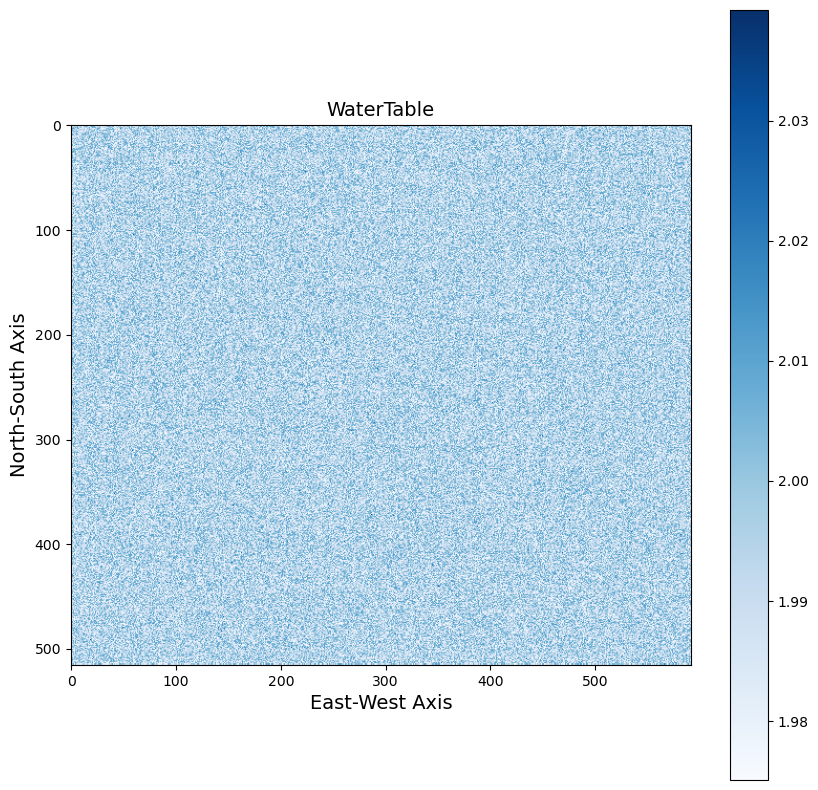

In [10]:
# plot the water level

def plot_water_table(timestep):
    #plot vegetation cover
    plt.figure(figsize=(10, 10))
    plt.imshow(W[:,:,timestep])

    plt.xlabel('East-West Axis', fontsize=14)
    plt.ylabel('North-South Axis', fontsize=14)
    plt.title('WaterTable', fontsize=14);
    plt.set_cmap("Blues")
    plt.colorbar()
    
    plt.show()
        
plot_water_table(7*24)